<a href="https://colab.research.google.com/github/mrshamshir/Cardiac-Detection/blob/main/Cardiac_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preprocessing

In [1]:
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 11.7 MB/s eta 0:00:00


In [2]:
from pathlib import Path
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [ ]:
!mkdir Data
!unzip /content/drive/MyDrive/rsna-pneumonia-detection-challenge.zip -d Data/

In [4]:
labels = pd.read_csv("/content/drive/MyDrive/rsna_heart_detection.csv")

In [5]:
print(labels.shape)
labels.head()

(496, 8)


,label,x0,y0,w,h,name,img_shape_x,img_shape_y
0,heart,91,71,77,102,ca112a3c-b701-48b8-a94f-725ea65416a7,224,224
1,heart,70,64,89,67,e5f292ae-f1e5-497c-b0a0-68f1aa2196b2,224,224
2,heart,82,55,81,76,67af68f7-7ba0-49a0-a373-3a8801eb0faa,224,224
3,heart,93,74,78,89,814289a3-9ce8-4cba-842f-45d6a36f540d,224,224
4,heart,85,61,85,93,e508969f-c931-462b-aa90-ccde34a4d9e5,224,224


In [6]:
ROOT_PATH = Path("/content/Data/stage_2_train_images")
SAVE_PATH = Path("Processed-Heart-Detection/")

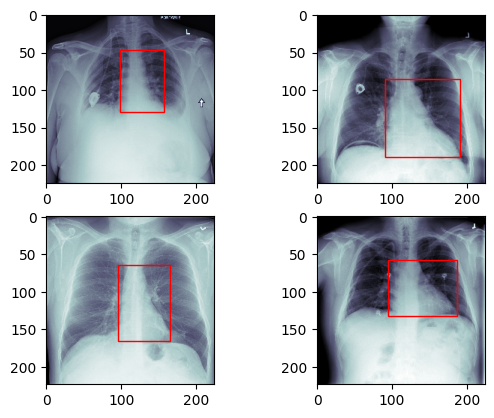

In [13]:
fig, axis = plt.subplots(2, 2)
c = 100
for i in range(2):
    for j in range(2):
        data = labels.iloc[c]  # Get the c-th row of the labels

        patient_id = data["name"]
        dcm_path = ROOT_PATH/str(patient_id)  # Create the path to the dcm file
        dcm_path = dcm_path.with_suffix(".dcm")  # And add the .dcm suffix
        dcm = pydicom.read_file(dcm_path)  # Read the dicom file with pydicom

        # Retrieve the actual image and resize it to match the labels
        dcm_array = dcm.pixel_array
        dcm_array = cv2.resize(dcm_array, (224, 224))

        x = data["x0"]
        y = data["y0"]
        width = data["w"]
        height = data["h"]

        axis[i][j].imshow(dcm_array, cmap="bone")
        rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
        axis[i][j].add_patch(rect)

        c+=1



In [7]:
sums = 0
sums_squared = 0
train_ids = []
val_ids = []

for counter, patient_id in enumerate(list(labels.name)):
    dcm_path = ROOT_PATH/patient_id  # Create the path to the dcm file
    dcm_path = dcm_path.with_suffix(".dcm")  # And add the .dcm suffix

    dcm = pydicom.read_file(dcm_path)  # Read the dicom file with pydicom

     # Retrieve the actual image
    dcm_array = dcm.pixel_array
    assert dcm_array.shape == (1024, 1024)

    # Resize the image to drastically improve training speed
    # In order to reduce the space when storing the image we convert it to float16
    # Standardize to 0-1 range
    dcm_array = (cv2.resize(dcm_array, (224, 224)) / 255).astype(np.float16)

    # 4/5 train split, 1/5 val split
    train_or_val = "train" if counter < 400 else "val"

    # Add to corresponding train or validation patient index list
    if train_or_val == "train":
        train_ids.append(patient_id)
    else:
        val_ids.append(patient_id)

    current_save_path = SAVE_PATH/train_or_val # Define save path and create if necessary
    current_save_path.mkdir(parents=True, exist_ok=True)

    np.save(current_save_path/patient_id, dcm_array)  # Save the array in the corresponding directory

    normalizer = dcm_array.shape[0] * dcm_array.shape[1]  # Normalize sum of image
    if train_or_val == "train":  # Only use train data to compute dataset statistics
        sums += np.sum(dcm_array) / normalizer
        sums_squared += (np.power(dcm_array, 2).sum()) / normalizer


In [8]:
# Store the train and val subject ids
np.save("Processed-Heart-Detection/train_subjects_det", train_ids)
np.save("Processed-Heart-Detection/val_subjects_det", val_ids)

In [9]:
mean = sums / len(train_ids)
std = np.sqrt(sums_squared / len(train_ids) - (mean**2), dtype=np.float64)

In [10]:
print(f"Mean of Dataset: {mean}, STD: {std}")

Mean of Dataset: 0.49430165816326493, STD: 0.2527964897943661


## Creating Dataset

In [11]:
from pathlib import Path
import torch
import numpy as np
import pandas as pd
import imgaug
from imgaug.augmentables.bbs import BoundingBox

In [12]:
class CardiacDataset(torch.utils.data.Dataset):

    def __init__(self, path_to_labels_csv, patients, root_path, augs):

        self.labels = pd.read_csv(path_to_labels_csv)

        self.patients = np.load(patients)
        self.root_path = Path(root_path)
        self.augment = augs

    def  __len__(self):
        """
        Returns the length of the dataset
        """
        return len(self.patients)

    def __getitem__(self, idx):
        """
        Returns an image paired with bbox around the heart
        """
        patient = self.patients[idx]
        # Get data according to index
        data = self.labels[self.labels["name"]==patient]

        # Get entries of given patient
        # Extract coordinates

        x_min = data["x0"].item()
        y_min = data["y0"].item()
        x_max = x_min + data["w"].item()  # get xmax from width
        y_max = y_min + data["h"].item()  # get ymax from height
        bbox = [x_min, y_min, x_max, y_max]


        # Load file and convert to float32
        file_path = self.root_path/patient  # Create the path to the file
        img = np.load(f"{file_path}.npy").astype(np.float32)


        # Apply imgaug augmentations to image and bounding box
        if self.augment:

            bb = BoundingBox(x1=bbox[0], y1=bbox[1], x2=bbox[2], y2=bbox[3])

            ###################IMPORTANT###################
            # Fix for https://discuss.pytorch.org/t/dataloader-workers-generate-the-same-random-augmentations/28830/2
            # https://github.com/pytorch/pytorch/issues/5059
            random_seed = torch.randint(0, 1000000, (1,)).item()
            imgaug.seed(random_seed)
            #####################################################

            img, aug_bbox  = self.augment(image=img, bounding_boxes=bb)
            bbox = aug_bbox[0][0], aug_bbox[0][1], aug_bbox[1][0], aug_bbox[1][1]


        # Normalize the image according to the values computed in Preprocessing
        img = (img - 0.494) / 0.252

        img = torch.tensor(img).unsqueeze(0)
        bbox = torch.tensor(bbox)

        return img, bbox


### Validate functionality

In [13]:
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [21]:
# First create the augmentation object

seq = iaa.Sequential([
            iaa.GammaContrast(),
            iaa.Affine(
                scale=(0.8, 1.2),
                rotate=(-10, 10),
                translate_px=(-10, 10)
            )
        ])


In [22]:
labels_path = "/content/drive/MyDrive/rsna_heart_detection.csv"
patients_path = "/content/Processed-Heart-Detection/train_subjects_det.npy"
train_root = "/content/Processed-Heart-Detection/train"
dataset = CardiacDataset(labels_path, patients_path, train_root, seq)

tensor([ 81.9707,  82.4367, 184.8383, 197.0258])


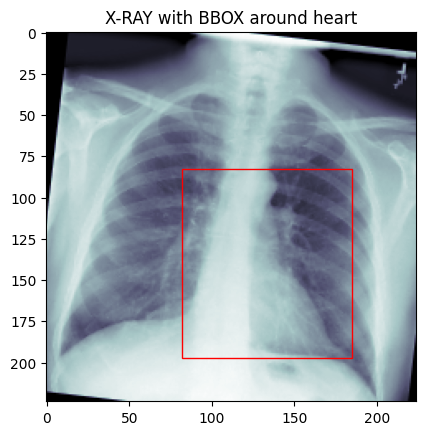

In [31]:
img, label = dataset[12]

fig, axis = plt.subplots(1, 1)
axis.imshow(img[0], cmap="bone")
spot1 = patches.Rectangle((label[0], label[1]), label[2]-label[0], label[3]-label[1], edgecolor='r', facecolor='none')
axis.add_patch(spot1)

axis.set_title("X-RAY with BBOX around heart")
print(label)


## Train

In [14]:
!pip install pytorch_lightning

In [15]:
import torch
import torchvision
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import numpy as np
import cv2
import imgaug.augmenters as iaa

In [16]:
# Create the dataset objects and the augmentation parameters to specify the augmentation parameters
train_root_path = "/content/Processed-Heart-Detection/train"
train_subjects = "/content/Processed-Heart-Detection/train_subjects_det.npy"
val_root_path = "/content/Processed-Heart-Detection/val"
val_subjects = "/content/Processed-Heart-Detection/val_subjects_det.npy"

train_transforms = iaa.Sequential([
                                iaa.GammaContrast(),
                                iaa.Affine(
                                    scale=(0.8, 1.2),
                                    rotate=(-10, 10),
                                    translate_px=(-10, 10)
                                )
                            ])

In [17]:
train_dataset = CardiacDataset("/content/drive/MyDrive/rsna_heart_detection.csv",
                               train_subjects, train_root_path, train_transforms)
val_dataset = CardiacDataset("/content/drive/MyDrive/rsna_heart_detection.csv",
                             val_subjects, val_root_path, None)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 400 train images and 96 val images


In [18]:
batch_size = 8
num_workers = 2


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)


### Model Creation

Architecture: Resnet18

1. 4 outputs: We need to estimate the location of the heart (xmin, ymin, xmax, ymax).
2. Loss function: We are going to use the L2 loss (Mean Squared Error), as we are dealing with continuous values.

In [19]:
class CardiacDetectionModel(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.model = torchvision.models.resnet18(pretrained=True)

        # Change conv1 from 3 to 1 input channels
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        # Change out_feature of the last fully connected layer (called fc in resnet18) from 1000 to 4
        self.model.fc = torch.nn.Linear(in_features=512, out_features=4)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.MSELoss()

    def forward(self, data):
        pred = self.model(data)
        return pred

    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()  # Convert label to float (just needed for loss computation)
        pred = self(x_ray)
        loss = self.loss_fn(pred, label)  # Compute the loss

        # Log loss
        self.log("Train Loss", loss)
        if batch_idx % 50 == 0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "Train")

        return loss


    def validation_step(self, batch, batch_idx):
        # Same steps as in the training_step
        x_ray, label = batch
        label = label

        label = label.float()  # Convert label to float (just needed for loss computation)
        pred = self(x_ray)

        loss = self.loss_fn(pred, label)
        self.log("Val Loss", loss)
        if batch_idx % 50 == 0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "Val")
        return loss

    def log_images(self, x_ray, pred, label, name):
        results = []

        # Here we create a grid consisting of 4 predictions
        for i in range(4):
            coords_labels = label[i]
            coords_pred = pred[i]
            img = ((x_ray[i] * 0.252)+0.494).numpy()[0]

            # Extract the coordinates from the label
            x0, y0 = coords_labels[0].int().item(), coords_labels[1].int().item()
            x1, y1 = coords_labels[2].int().item(), coords_labels[3].int().item()
            img = cv2.rectangle(img, (x0, y0), (x1, y1), (0, 0, 0), 2)

            # Extract the coordinates from the prediction
            x0, y0 = coords_pred[0].int().item(), coords_pred[1].int().item()
            x1, y1 = coords_pred[2].int().item(), coords_pred[3].int().item()
            img = cv2.rectangle(img, (x0, y0), (x1, y1), (1, 1, 1), 2)


            results.append(torch.tensor(img).unsqueeze(0))
        grid = torchvision.utils.make_grid(results, 2)
        self.logger.experiment.add_image(f"{name} Prediction vs Label", grid, self.global_step)



    def configure_optimizers(self):
        #Caution! You always need to return a list here (just pack your optimizer into one :))
        return [self.optimizer]



In [20]:
# Create the model object
model = CardiacDetectionModel()  # Instanciate the model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 264MB/s]


### Training

In [21]:
# Create the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='Val Loss',
    save_top_k=10,
    mode='min')

In [22]:
# Create the trainer
# Change the gpus parameter to the number of available gpus in your computer. Use 0 for CPU training

trainer = pl.Trainer(accelerator="auto", logger=TensorBoardLogger("/content/drive/MyDrive/output"),
                     log_every_n_steps=1,
                     callbacks=checkpoint_callback,
                     max_epochs=100)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [23]:
# Train the detection model
trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type    | Params
------------------------------------
0 | model   | ResNet  | 11.2 M
1 | loss_fn | MSELoss | 0     
------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.689    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


## Evaluation

In [24]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.load_from_checkpoint("/content/drive/MyDrive/output/lightning_logs/version_1/checkpoints/epoch=98-step=4950.ckpt")
model.eval();
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CardiacDetectionModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [26]:
preds = []
labels = []

with torch.no_grad():
    for data, label in val_dataset:
        data = data.to(device).float().unsqueeze(0)
        pred = model(data)[0].cpu()
        preds.append(pred)
        labels.append(label)

preds=torch.stack(preds)
labels=torch.stack(labels)

In [27]:
# Compute mean deviation between prediction and labels for each coordinate
abs(preds-labels).mean(0)

tensor([4.7176, 5.5101, 6.1061, 4.4500])

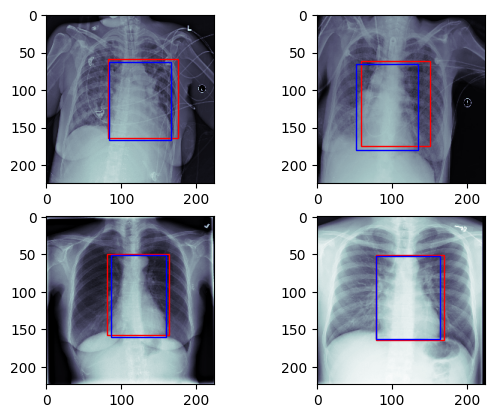

In [41]:
# Example prediction:
fig, axis = plt.subplots(2, 2)
IDX = 40  # Feel free to inspect all validation samples by changing the index

for i in range(2):
    for j in range(2):

        img, label = val_dataset[IDX]
        current_pred = preds[IDX]


        axis[i][j].imshow(img[0], cmap="bone")
        heart = patches.Rectangle((current_pred[0], current_pred[1]), current_pred[2]-current_pred[0],
                                current_pred[3]-current_pred[1], linewidth=1, edgecolor='r', facecolor='none')
        axis[i][j].add_patch(heart)


        rect = patches.Rectangle((label[0], label[1]), label[2]-label[0],
                                label[3]-label[1], linewidth=1, edgecolor='b', facecolor='none')
        axis[i][j].add_patch(rect)

        IDX+=1
